In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [ ]:
api_token = {"username":"<usernam>","key":"<apikey>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 92% 136M/149M [00:00<00:00, 272MB/s]
100% 149M/149M [00:00<00:00, 272MB/s]


In [ ]:
!unzip -qq brain-tumor-mri-dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization

from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [ ]:
tf.keras.utils.set_random_seed(1234)


In [ ]:
imagePaths = "Training"
test_path="Testing"

In [ ]:
!ls -al Testing

total 64
drwxr-xr-x 6 root root  4096 Jun 12 15:22 .
drwxr-xr-x 1 root root  4096 Jun 12 15:22 ..
drwxr-xr-x 2 root root 12288 Jun 12 15:22 glioma
drwxr-xr-x 2 root root 12288 Jun 12 15:22 meningioma
drwxr-xr-x 2 root root 20480 Jun 12 15:22 notumor
drwxr-xr-x 2 root root 12288 Jun 12 15:22 pituitary


In [ ]:
batch_size= 32
img_height = 224
img_width = 224

# Training, Validation and Test Datasets

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = train_ds

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 1311 files belonging to 4 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


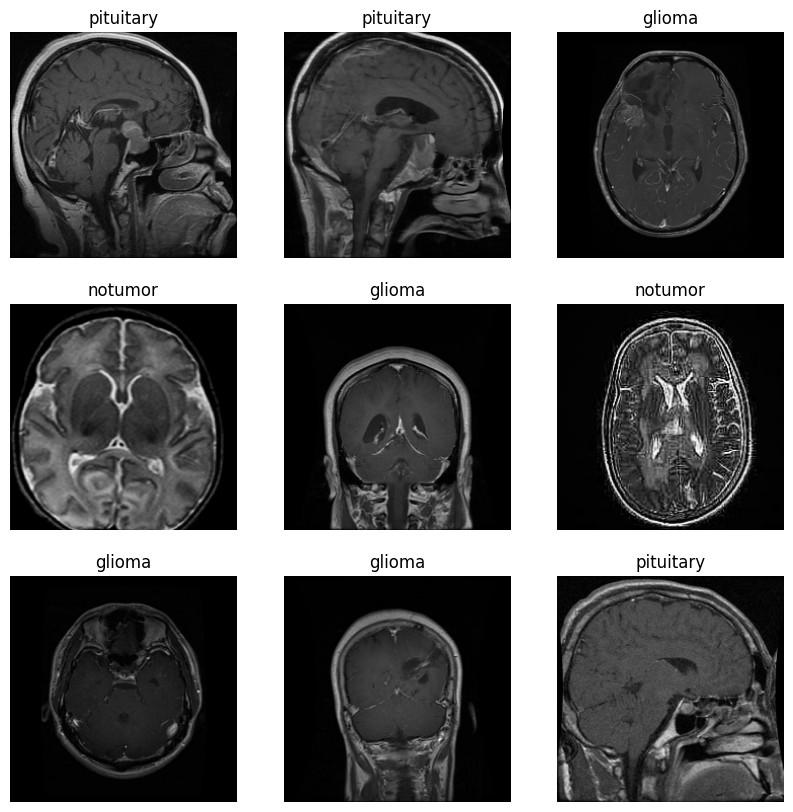

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data Augmentation for our Dataset
###### (Flip in horizontal plane and change brightness level)

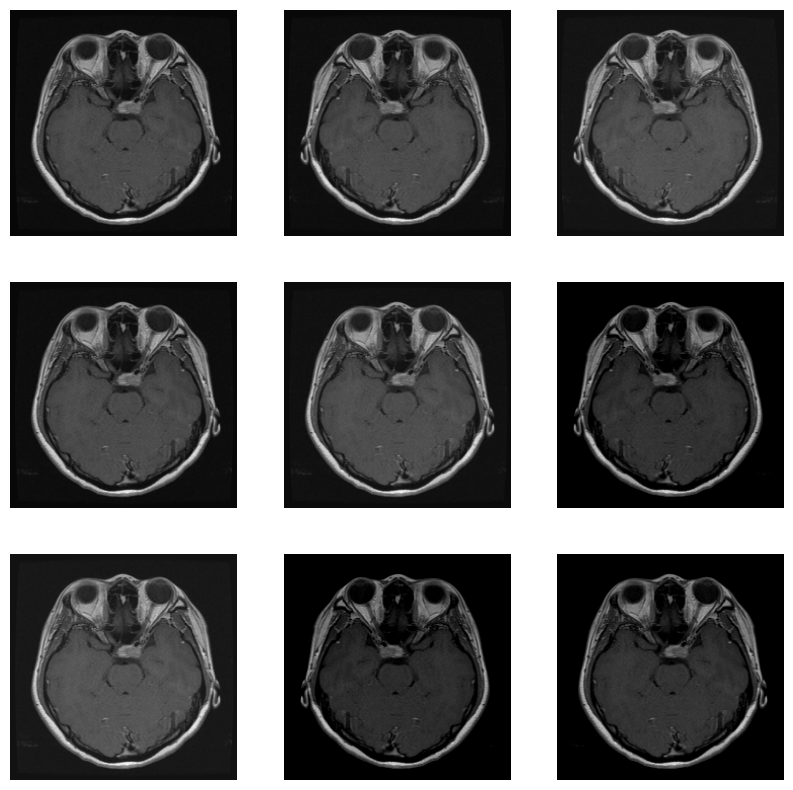

In [ ]:
data_augmentation = Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Transfer Learning
##### - We used weights that we got from ImageNet


In [ ]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)

x = Dense(8, activation='relu')(x)

x = Dense(4, activation='softmax')(x)

model = Model(inputs=resnet_base.input,
              outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Early Stopping Point
##### If the validation loss does not improve six times, we have set an early stopping point that will stop the model training.


In [ ]:
def get_early_stopping():

    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
def get_checkpoint_best_only():
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [ ]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

# Training Model

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=100, callbacks=callbacks)

Epoch 1/100
152/152 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.8268
Epoch 1: val_accuracy improved from -inf to 0.38983, saving model to checkpoints_best_only


152/152 [==============================] - 149s 639ms/step - loss: 0.5430 - accuracy: 0.8268 - val_loss: 5.0954 - val_accuracy: 0.3898
Epoch 2/100
152/152 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9174
Epoch 2: val_accuracy improved from 0.38983 to 0.85626, saving model to checkpoints_best_only


152/152 [==============================] - 95s 627ms/step - loss: 0.2377 - accuracy: 0.9174 - val_loss: 0.4981 - val_accuracy: 0.8563
Epoch 3/100
152/152 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9436
Epoch 3: val_accuracy improved from 0.85626 to 0.88262, saving model to checkpoints_best_only


152/152 [==============================] - 98s 643ms/step - loss: 0.1661 - accuracy: 0.9436 - val_loss: 0.3893 - val_accuracy: 0.8826
Epoch 4/100
152/152 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9522
Epoch 4: val_accuracy did not improve from 0.88262
152/152 [==============================] - 73s 477ms/step - loss: 0.1379 - accuracy: 0.9522 - val_loss: 3.7753 - val_accuracy: 0.4333
Epoch 5/100
152/152 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9679
Epoch 5: val_accuracy did not improve from 0.88262
152/152 [==============================] - 73s 482ms/step - loss: 0.1020 - accuracy: 0.9679 - val_loss: 0.4039 - val_accuracy: 0.8614
Epoch 6/100
152/152 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9755
Epoch 6: val_accuracy improved from 0.88262 to 0.91083, saving model to checkpoints_best_only


152/152 [==============================] - 103s 679ms/step - loss: 0.0846 - accuracy: 0.9755 - val_loss: 0.2746 - val_accuracy: 0.9108
Epoch 7/100
152/152 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9872
Epoch 7: val_accuracy did not improve from 0.91083
152/152 [==============================] - 73s 478ms/step - loss: 0.0429 - accuracy: 0.9872 - val_loss: 0.2960 - val_accuracy: 0.8937
Epoch 8/100
152/152 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9788
Epoch 8: val_accuracy did not improve from 0.91083
152/152 [==============================] - 73s 476ms/step - loss: 0.0679 - accuracy: 0.9788 - val_loss: 0.4437 - val_accuracy: 0.8886
Epoch 9/100
152/152 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9718
Epoch 9: val_accuracy did not improve from 0.91083
152/152 [==============================] - 73s 477ms/step - loss: 0.0852 - accuracy: 0.9718 - val_loss: 0.4955 - val_accuracy: 0.8431
Epoch 10/100
152/15

152/152 [==============================] - 99s 649ms/step - loss: 0.0532 - accuracy: 0.9829 - val_loss: 0.2290 - val_accuracy: 0.9145
Epoch 11/100
152/152 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9926
Epoch 11: val_accuracy improved from 0.91454 to 0.95572, saving model to checkpoints_best_only


152/152 [==============================] - 98s 644ms/step - loss: 0.0260 - accuracy: 0.9926 - val_loss: 0.1126 - val_accuracy: 0.9557
Epoch 12/100
152/152 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9860
Epoch 12: val_accuracy did not improve from 0.95572
152/152 [==============================] - 74s 487ms/step - loss: 0.0451 - accuracy: 0.9860 - val_loss: 2.6423 - val_accuracy: 0.5144
Epoch 13/100
152/152 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9868
Epoch 13: val_accuracy did not improve from 0.95572
152/152 [==============================] - 73s 477ms/step - loss: 0.0368 - accuracy: 0.9868 - val_loss: 0.2979 - val_accuracy: 0.9217
Epoch 14/100
152/152 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9798
Epoch 14: val_accuracy did not improve from 0.95572
152/152 [==============================] - 73s 477ms/step - loss: 0.0615 - accuracy: 0.9798 - val_loss: 0.3425 - val_accuracy: 0.9180
Epoch 15/100
1

#

In [ ]:
model.load_weights("checkpoints_best_only")

In [ ]:
model.evaluate(test_ds)

41/41 [==============================] - 6s 127ms/step - loss: 0.2368 - accuracy: 0.9268


[0.23678767681121826, 0.9267734289169312]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 1s 898ms/step


[[255  30  12   3]
 [  2 272  19  13]
 [  0   0 404   1]
 [  0   4  12 284]]


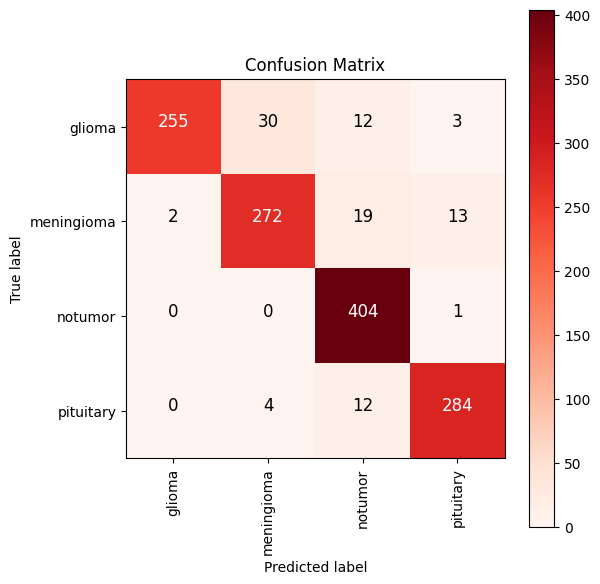

In [ ]:
classes=['glioma','meningioma', 'notumor','pituitary']
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.99      0.85      0.92       300
  meningioma       0.89      0.89      0.89       306
     notumor       0.90      1.00      0.95       405
   pituitary       0.94      0.95      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



# Saving our model to use in the other data

In [ ]:
model.save("brain_model.h5")

##  Drawing Accuracy and Loss Curves

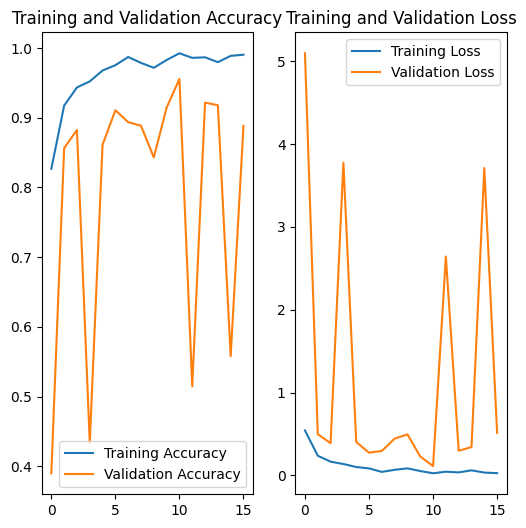

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#early stopping epoch estimate
epochs_range = range(16)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from IPython.display import Image, display


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def predict(imgPath):
  test_img = cv2.imread(imgPath)
  dim = (224, 224)

  test_img = cv2.resize(test_img, dim)
  test_img = asarray(test_img)
  test_img=np.reshape(test_img, (-1, 224, 224, 3))
  preds = model.predict(test_img)
  tumor_index = preds.argmax(axis=1)
  tumor_names = dict(zip(preds[0],classes))

  tumor_name = list(tumor_names.values())[(tumor_index[0])]
  print("\nThe Ground Truth:", target_names[(tumor_index[0])])
  print("Prediction:", tumor_name)
  print("Predicted:", preds[0],"\n")

  heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name)

  plt.matshow(heatmap)
  plt.title(tumor_name)
  plt.show()

In [ ]:
# ön trying
img_path = tf.keras.utils.get_file(
    "tumor.jpg",
    "https://scx2.b-cdn.net/gfx/news/hires/2009/acrystalball.jpg"
)


20915/20915 [==============================] - 0s 0us/step


# Make the picture appropriate for the model

In [ ]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size) #<3
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

In [ ]:
img_array = get_img_array(img_path, target_size=(224, 224))
last_conv_layer_name = "conv5_block3_out"
# Remove last layer's softmax
model.layers[-1].activation = None

1/1 [==============================] - 1s 565ms/step

The Ground Truth: meningioma
Prediction: meningioma
Predicted: [5.2893108e-07 4.6083690e-03 2.8228438e-01 7.1310669e-01] 



<ipython-input-35-d1555b940b6f>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  tumor_name = list(tumor_names.values())[(tumor_index == np.int32)+1]


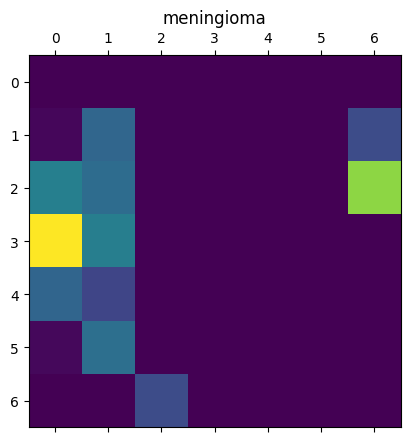

In [ ]:
# Print what the top predicted class is
preds = model.predict(img_array)
tumor_index = preds.argmax(axis=1)
tumor_names = dict(zip(preds[0],classes))
tumor_name = list(tumor_names.values())[(tumor_index == np.int32)+1]
print("\nThe Ground Truth:", "meningioma")
print("Prediction:", tumor_name)
print("Predicted:", preds[0],"\n")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.title(tumor_name)
plt.show()

In [ ]:
import matplotlib.cm as matcm

In [ ]:
from IPython.display import Image, display


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

<ipython-input-37-5caeab657a1b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = matcm.get_cmap("jet")


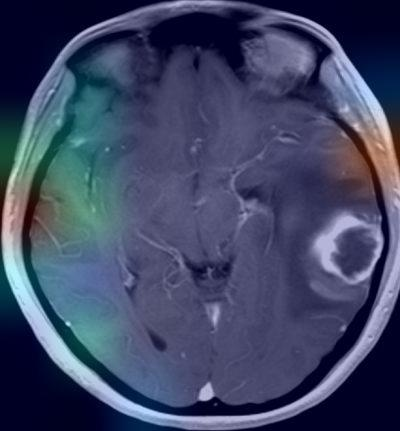

In [ ]:

save_and_display_gradcam(img_path, heatmap)

In [ ]:
import cv2

from numpy import asarray

In [ ]:
test_img = cv2.imread("/content/Testing/meningioma/Te-meTr_0003.jpg")
dim = (224, 224)

# resize image
test_img = cv2.resize(test_img, dim)

test_img = asarray(test_img)
test_img=np.reshape(test_img, (-1, 224, 224, 3))

<ipython-input-37-5caeab657a1b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = matcm.get_cmap("jet")


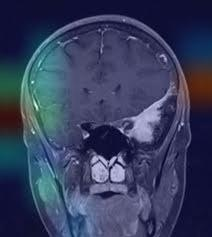

In [ ]:
save_and_display_gradcam("/content/Testing/meningioma/Te-meTr_0003.jpg", heatmap)


1/1 [==============================] - 1s 946ms/step

The Ground Truth: meningioma
Prediction: meningioma
Predicted: [ 2.010867   12.121588    0.47594902  4.121048  ] 



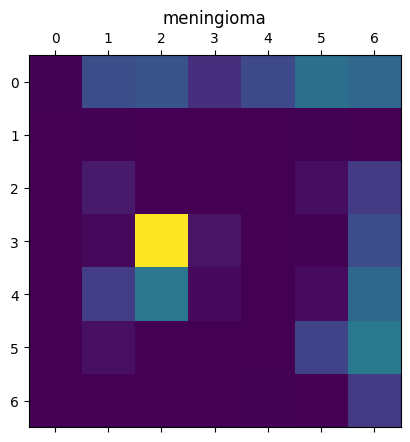

In [ ]:
test_img = ("/content/Testing/meningioma/Te-me_0152.jpg")
predict(test_img)

<ipython-input-37-5caeab657a1b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = matcm.get_cmap("jet")


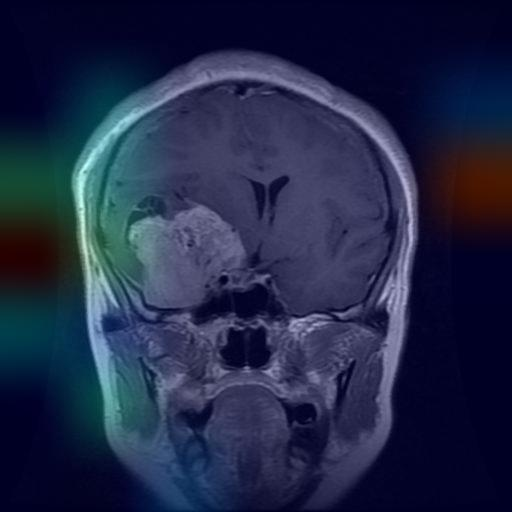

In [ ]:
save_and_display_gradcam("/content/Testing/meningioma/Te-me_0152.jpg", heatmap)


1/1 [==============================] - 0s 25ms/step

The Ground Truth: pituitary
Prediction: pituitary
Predicted: [-14.154374   -3.3794997  -2.274701    1.1866236] 



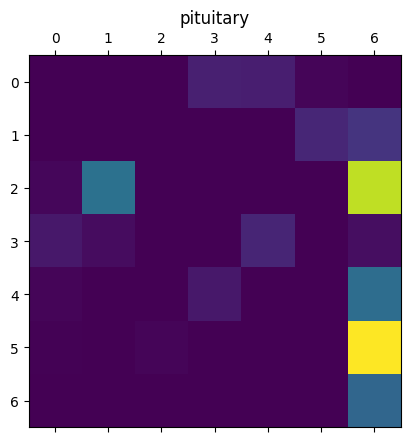

In [ ]:
predict("/content/Testing/pituitary/Te-piTr_0003.jpg")